# Interactive Sign Language Detection
## Vineetha C - 21BAI1358
### Machine Vision

### I. Import modules

In [1]:
import cv2
import time
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import mediapipe as mp
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, MultiHeadAttention, Input, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix

### II. Mediapipe utils

In [2]:
# Download the holistic model
mp_model = mp.solutions.holistic
# Drawing util
mp_draw = mp.solutions.drawing_utils

### III. Create and prepare dataset

In [3]:
DATA_PATH = 'dataset'
actions = np.array(['hello', 'thanks', 'welcome', 'sorry', 'yes', 'strong'])
num_videos_per_action = 60
num_frames_per_video = 30

In [4]:
def setup_data_folders():
    """Prepare folder structure for storing extracted keypoints"""
    for action in actions:
        try:
            os.makedirs(os.path.join(DATA_PATH, action))
        except FileExistsError:
            pass

#### Detect signs and mark keypoints

In [5]:
def detect_sign_pose(image, model):
    """Detect sign from frame using holistic model"""
    # Convert input feed from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    # Detect the sign on the non-writable image
    # The model here is the holistic model downloaded from mediapipe
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [6]:
def show_landmarks(image, results):
    """Draw hand and shoulder landmarks on image using mediapipe utils"""
    mp_draw.draw_landmarks(image, results.pose_landmarks, mp_model.POSE_CONNECTIONS)
    mp_draw.draw_landmarks(image, results.left_hand_landmarks, mp_model.HAND_CONNECTIONS)
    mp_draw.draw_landmarks(image, results.right_hand_landmarks, mp_model.HAND_CONNECTIONS)

In [7]:
def extract_keypoints(results):
    """Extract keypoints from mediapipe results for both hands"""
    # Flattening for LSTM input
    # And handle empty arrays when no input is given for that particular 
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return np.concatenate([pose, lh, rh])

In [8]:
def capture_keypoints():
    """Capture keypoints for each action and store as .npy files"""
    cap = cv2.VideoCapture(0)
    with mp_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        # Go through every action
        for action in actions:
            # Go through videos for each action
            for seq in range(num_videos_per_action):
                # Take a second between every video
                time.sleep(1)

                seq_dir = os.path.join(DATA_PATH, action, str(seq))
                os.makedirs(seq_dir, exist_ok=True)

                # Go through frames in every video of an action
                for frame_num in range(num_frames_per_video):
                    # Capture live feed from camera
                    ret, frame = cap.read()
                    # Detect sign on live feed
                    frame, results = detect_sign_pose(frame, holistic)
                    # Display landmarks in feed
                    show_landmarks(frame, results)
                    # Display collection status
                    cv2.putText(frame, f'Collecting frames for Action: {action} - Video number: {seq}', (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 
                                0.5, (255, 0, 0), 1, cv2.LINE_AA)
                    # Show live feed on screen
                    cv2.imshow('Live feed', frame)

                    # Save keypoints in folders
                    keypoints = extract_keypoints(results)
                    np.save(os.path.join(seq_dir, str(frame_num)), keypoints)

                    # Press q to exit from live capture
                    if cv2.waitKey(10) & 0xFF == ord('q'):
                        break
    cap.release()
    cv2.destroyAllWindows()

#### Adding data from feed into created folders

In [9]:
def prepare_data():
    """Load data from .npy files into sequences (Input -> X) and labels (Output -> y)"""
    sequences, labels = [], []
    label_map = {label: num for num, label in enumerate(actions)}
    for action in actions:
        for sequence in range(num_videos_per_action):
            window = []
            for frame_num in range(num_frames_per_video):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    return np.array(sequences), to_categorical(labels)

### IV. Models

In [10]:
def create_model1(X):
    """Define and compile the enhanced LSTM model with dropouts"""
    model = Sequential([
        LSTM(128, return_sequences=True, activation='relu', 
             input_shape=(num_frames_per_video, X.shape[2]), 
             dropout=0.3, recurrent_dropout=0.3),
            
        LSTM(256, return_sequences=True, activation='relu',
             dropout=0.3, recurrent_dropout=0.3),
            
        LSTM(128, return_sequences=False, activation='relu',
             dropout=0.3, recurrent_dropout=0.3),
            
        Dense(128, activation='relu'),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(actions.shape[0], activation='softmax')
    ])
    
    model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

In [11]:
def create_model2(X):
    """
    Create an enhanced model for sign language recognition using LSTM, attention mechanisms, and skip connections
    """
    inputs = Input(shape=(num_frames_per_video, X.shape[2]))
    
    x1 = LSTM(128, return_sequences=True, activation='tanh')(inputs)
    x1 = Dropout(0.3)(x1)
    x1 = LayerNormalization()(x1)
    
    attention_output = MultiHeadAttention(
        num_heads=8, key_dim=32
    )(x1, x1, x1)
    attention_output = Dropout(0.2)(attention_output)
    x2 = LayerNormalization()(attention_output + x1)
    
    x3 = LSTM(256, return_sequences=True, activation='tanh')(x2)
    x3 = Dropout(0.3)(x3)
    x3 = LayerNormalization()(x3)
    
    attention_output_2 = MultiHeadAttention(
        num_heads=8, key_dim=32
    )(x3, x3, x3)
    attention_output_2 = Dropout(0.2)(attention_output_2)
    x4 = LayerNormalization()(attention_output_2 + x3)
    
    x5 = LSTM(128, return_sequences=True, activation='tanh')(x4)
    x5 = LayerNormalization()(x5)
    
    x6 = GlobalAveragePooling1D()(x5)
    
    x7 = Dense(256, activation='relu')(x6)
    x7 = Dropout(0.4)(x7)
    x8 = Dense(128, activation='relu')(x7)
    x8 = Dropout(0.3)(x8)
    
    outputs = Dense(actions.shape[0], activation='softmax')(x8)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

### V. Real-time prediction

#### Prints the sign and confidence score (no display on live feed)

In [55]:
# def real_time_sign_recognition(model2):
#     """Real-time sign recognition with feedback (only confidence score and message)"""
#     cap = cv2.VideoCapture(0)
    
#     with mp_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#         sequence = []
#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 break

#             # Detect the sign pose
#             frame, results = detect_sign_pose(frame, holistic)

#             # Collect keypoints from detected pose
#             keypoints = extract_keypoints(results)
#             sequence.append(keypoints)
#             sequence = sequence[-30:]  # Keep only the last 30 frames for prediction

#             # Prediction and feedback after collecting 30 frames
#             if len(sequence) == 30:
#                 # Model prediction
#                 res = model2.predict(np.expand_dims(sequence, axis=0))[0]
#                 predicted_class = np.argmax(res)
#                 confidence = np.max(res)
#                 action = actions[predicted_class]

#                 # Provide feedback
#                 feedback = f"Prediction: {action} - Confidence: {confidence*100:.2f}%"

#                 # Display feedback on the frame
#                 print(feedback)  # You can use print or overlay the feedback on the frame

#             # Display the real-time frame
#             cv2.imshow('Real-Time Sign Language Detection', frame)

#             # Exit on pressing 'q'
#             if cv2.waitKey(10) & 0xFF == ord('q'):
#                 break

#     cap.release()
#     cv2.destroyAllWindows()

#### Displays the sign and confidence score on live feed

In [56]:
# def real_time_sign_recognition(model2):
#     """Real-time sign recognition with feedback (action and confidence on feed)"""
#     cap = cv2.VideoCapture(0)
    
#     with mp_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#         sequence = []
#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 break

#             # Detect the sign pose
#             frame, results = detect_sign_pose(frame, holistic)

#             # Collect keypoints from detected pose
#             keypoints = extract_keypoints(results)
#             sequence.append(keypoints)
#             sequence = sequence[-30:]  # Keep only the last 30 frames for prediction

#             # Prediction and feedback after collecting 30 frames
#             if len(sequence) == 30:
#                 # Model prediction
#                 res = model2.predict(np.expand_dims(sequence, axis=0))[0]
#                 predicted_class = np.argmax(res)
#                 confidence = np.max(res)
#                 action = actions[predicted_class]

#                 # Provide feedback
#                 feedback = f"{action} - {confidence*100:.2f}%"

#                 # Display the feedback on the frame
#                 cv2.putText(frame, feedback, (15, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

#             # Show the frame with feedback
#             cv2.imshow('Real-Time Sign Language Detection', frame)

#             # Exit on pressing 'q'
#             if cv2.waitKey(10) & 0xFF == ord('q'):
#                 break

#     cap.release()
#     cv2.destroyAllWindows()

#### Displays sign, confidence score and message indicating the accuracy of what is being signed on live feed

In [57]:
def real_time_sign_recognition(model2):
    """Real-time sign recognition with feedback (confidence score, message, and guidance)"""
    cap = cv2.VideoCapture(0)
    
    with mp_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        sequence = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Detect the sign pose
            frame, results = detect_sign_pose(frame, holistic)

            # Collect keypoints from detected pose
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-30:]  # Keep only the last 30 frames for prediction

            # Prediction and feedback after collecting 30 frames
            if len(sequence) == 30:
                # Model prediction
                res = model2.predict(np.expand_dims(sequence, axis=0))[0]
                predicted_class = np.argmax(res)
                confidence = np.max(res)
                action = actions[predicted_class]

                # Provide feedback based on confidence
                if confidence >= 0.8:  # Confidence above 80%
                    feedback = f"Great! {action} - Confidence: {confidence*100:.2f}%"
                elif confidence >= 0.6:  # Confidence between 60% and 80%
                    feedback = f"You're getting closer! {action} - Confidence: {confidence*100:.2f}%"
                else:  # Confidence below 60%
                    feedback = f"Make the sign clearer! {action} - Confidence: {confidence*100:.2f}%"

                # Display feedback on the frame
                cv2.putText(frame, feedback, (15, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

            # Display the real-time frame
            cv2.imshow('Real-Time Sign Language Detection', frame)

            # Exit on pressing 'q'
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

### VI. Setup of data

In [16]:
setup_data_folders()

In [17]:
capture_keypoints()

### VII. Main execution

In [18]:
X, y = prepare_data()

In [19]:
# Check for input shape before making model
X.shape

(360, 30, 258)

### VIII. Splitting dataset for training and testing

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,     # Maintain class distribution
    random_state=42
)

### IX.Train, saving and evaluate the model

#### Generate the models

In [21]:
model1 = create_model1(X)
model2 = create_model2(X)

C:\Users\vinee\OneDrive\Desktop\SEM7\E_Machine Vision\Project\Code\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Train the model

In [22]:
model1.fit(X_train, y_train, epochs=500, verbose=0)

In [23]:
model2.fit(X_train, y_train, epochs=500, verbose=0)

#### Save the model weights

In [24]:
model1.save('sign_language_detection_model1.h5')
model2.save('sign_language_detection_model2.h5')

In [25]:
model1.save('sign_language_detection_model1.keras')
model2.save('sign_language_detection_model2.keras')

#### Evaluate the model

In [26]:
def display_metrics(y_true, y_pred, model_name):  
    cm = confusion_matrix(y_true, y_pred)  
    accuracy = accuracy_score(y_true, y_pred)  
    print(f'Accuracy for {model_name}: {accuracy:.2f}')  # Display accuracy  
    plt.figure(figsize=(6, 5))  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,  
                xticklabels=actions, yticklabels=actions)  
    plt.title(f'Confusion Matrix: {model_name} (Accuracy: {accuracy:.2f})')  
    plt.xlabel('Predicted')  
    plt.ylabel('True')  
    plt.show()  

In [35]:
# model1 = load_model('sign_language_detection_model1.h5')
model1 = load_model('sign_language_detection_model1.keras')

In [36]:
# model2 = load_model('sign_language_detection_model2.h5')
model2 = load_model('sign_language_detection_model2.keras')

In [38]:
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 514ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [39]:
y_ground = np.argmax(y_test, axis = 1).tolist()
y_pred1 = np.argmax(y_pred1, axis = 1).tolist()
y_pred2 = np.argmax(y_pred2, axis = 1).tolist()

In [25]:
# print(multilabel_confusion_matrix(y_ground, y_pred))
# print(accuracy_score(y_ground, y_pred))

Accuracy for <Sequential name=sequential, built=True>: 0.17


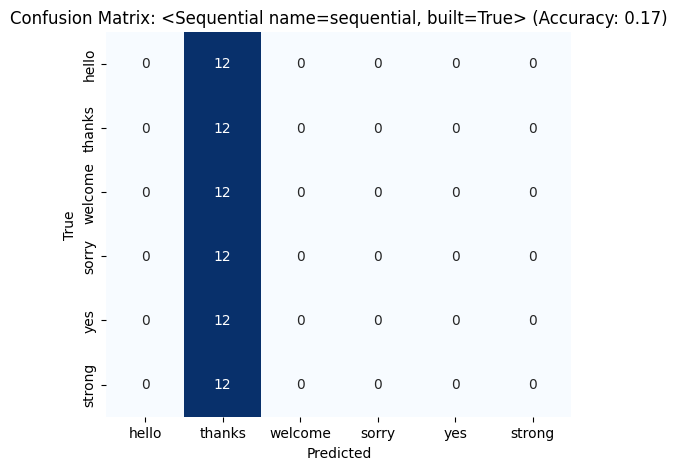

In [40]:
display_metrics(y_ground, y_pred1, model1)

Accuracy for <Functional name=functional_1, built=True>: 0.93


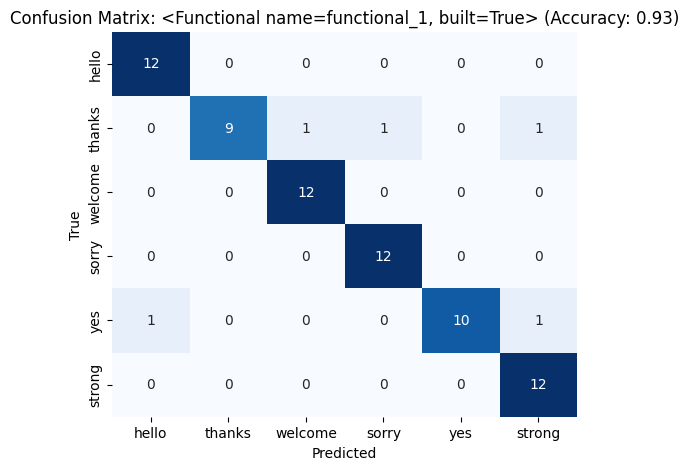

In [41]:
display_metrics(y_ground, y_pred2, model2)

### X. Predict and learn on feedback

In [54]:
real_time_sign_recognition(model2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━